This notebook is a continuation of the `fim_matching_IEEE39.ipynb`.
Here, we want to only look at some area in the network.
The information about the area is obtained from [matpower](https://matpower.org/docs/ref/matpower5.0/menu5.0.html), which references Cornell's [TC calculator](https://www.pserc.cornell.edu/tcc/tcc.md-SYSTEM=2.html).
The buses in the area are buses 15, 16, 19, 20, 21, 22, 23, 24, 28, 29, 33, 34, 35, 36, and 38.

In [1]:
from pathlib import Path
import json
import random

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from information_matching import ConvexOpt
from information_matching.precondition import preconditioner

random.seed(1)
%matplotlib inline
plt.style.use("default")

In [2]:
# Set directories
case = 39  # 39-bus case

WORK_DIR = Path().absolute()
FIM_DIR = WORK_DIR / "FIMs"
DATA_DIR = WORK_DIR / "models" / "data"

# Setup

First, remember that we only want to make measurement of the buses in the area and we only care about the observability of these buses.

In [3]:
# Load the area data, which contains information about which buses in the area
with open(DATA_DIR / "area_partition.json", "r") as f:
    area_dict = json.load(f)

area = "Area3"
buses_area = area_dict[area]

In [4]:
# Model information
nparams = 2 * case

In [5]:
# Configurations
nconfigs = len(buses_area)
configs = buses_area
config_ids = np.array([f"bus{ii}" for ii in configs])
config_ids

array(['bus15', 'bus16', 'bus19', 'bus20', 'bus21', 'bus22', 'bus23',
       'bus24', 'bus28', 'bus29', 'bus33', 'bus34', 'bus35', 'bus36',
       'bus38'], dtype='<U5')

In [6]:
# Load configuration FIMs
# Note that each candidate bus still measure the voltage phasor for all connected
# buses, even outside the area of interest.
fim_configs_tensor = np.empty((nconfigs, nparams, nparams))
for ii, bus in enumerate(configs):
    J = np.load(FIM_DIR / f"jacobian_bus{bus}.npy")
    I = J.T @ J
    fim_configs_tensor[ii] = I
# Precondition the configuration FIMs
fim_configs = preconditioner(
    {config_ids[ii]: fim for ii, fim in enumerate(fim_configs_tensor)},
    "max_frobenius",
)
fim_configs_tensor[0].shape

(78, 78)

In [7]:
# Target FIM
# Index of the parameters for observation within the area
idx_buses = np.array(buses_area) - 1  # buses zero-based index
idx_params = np.sort(np.append(2 * idx_buses, 2 * idx_buses + 1))

lambda_tol = 1e-5  # Eigenvalue cutoff
fim_target = np.diag(np.zeros(nparams))
fim_target[idx_params, idx_params] = np.ones_like(idx_params) * lambda_tol
print("Eigenvalue lower bound:", lambda_tol)

Eigenvalue lower bound: 1e-05


# Convex optimization

Additional note:

We will perform the optimization iteratively.
In each iteration, we scale the weights being optimize by the optimal weights from the previous iteration.
By doing so, the objective function in the convex optimization better mimics $\ell_0$-norm to enforce sparsity.

In [8]:
# Convex optimization
# Settings
cvx_tol = np.finfo(float).eps ** 0.75
solver = dict(verbose=False, warm_start=True, solver="SDPA", epsilonStar=cvx_tol)
print("Tolerance:", cvx_tol)

result_dict = {}
for trial in range(50):
    # Try several small initial guesses
    wopt = np.zeros(nconfigs)
    idx = random.sample(range(nconfigs), 12)
    # result_dict.update({trial: {"init_idx": idx}})
    wopt[idx] = 1.0
    
    # Iterative optimization to mimic l0-norm objective
    for ii in range(20):
        # Update the weight scales
        for jj, identifier in enumerate(config_ids):
            # Add weight scale information,add some small number for numerical stability
            fim_configs[identifier].update({"weight_scale": 1 / (wopt[jj] + 1e-15)})
        cvxopt = ConvexOpt(fim_target, fim_configs, l1norm_obj=True)

        try:
            # Solve
            if ii == 0:
                cvxopt.wm.value = wopt.reshape((-1, 1))
            cvxopt.solve(**solver)
            result = cvxopt.result.copy()
            wopt = result["wm"]
            dual = result["dual_wm"]
            print("Violation:", cvxopt.constraints[1].violation())
        except Exception:
            cvxopt.result = result
            break

    result_dict.update({trial: result})

Tolerance: 1.8189894035458565e-12
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
ARPACK error -1: No convergence (781 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
Violation: 4.0787308623634895e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp


/home/yonatank/myenv3.9/lib64/python3.9/site-packages/cvxpy/reductions/solvers/conic_solvers/sdpa_conif.py:175: RuntimeWarning: Python recalculation of primal and/or dual feasibility error failed due to numerical issues in eigenvalue computation. SDPA for Python is only able to report the feasibility errors computed by the backend solver.
  x, y, sdpapinfo, timeinfo, sdpainfo = sdpap.solve(
/home/yonatank/myenv3.9/lib64/python3.9/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


ARPACK error -1: No convergence (781 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
Violation: 1.2227211533592909e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
ARPACK error -1: No convergence (781 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
Violation: 2.217252765994332e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
ARPACK error -1: No convergence (781 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]
Violation: 1.3768387192820448e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
ARPACK error -1: No convergence (781 iterati

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1541090582945673e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1284244071124925e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1353788337995497e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1471848882364782e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.152198700915144e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1542170629869657e-08
Step length is too small.  :: line 

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.0302178494947327e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.0230470907422592e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.0253530912763835e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.039141208277345e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.203795635190383e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.8191303864055425e-08
Step length is too small.  :: line 1

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.7791021715861763e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.0642472702085234e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.167923524580335e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.2111380126470827e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.2293177256023636e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.236803081819791e-08
Step length is too small.  :: line 1

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.3469300479451684e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.3505311724748873e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.3479319863506537e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.3479448451940754e-08
cholesky miss condition :: not positive definite :: info = 22 :: line 784 in sdpa_linear.cpp
There are some possibilities. :: line 786 in sdpa_linear.cpp
1. SDPA terminates due to inaccuracy of numerical error :: line 787 in sdpa_linear.cpp
2. The input problem may not have (any) interior-points :: line 788 in sdpa_linear.cpp
3. Input matrices are linear

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 4.609535691665748e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.2482527949054875e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 4.802245420369772e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 6.37320910699948e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 8.640110552521287e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.558017929550036e-08
Step length is too small.  :: line 198 i

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.269451644110714e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.2694884388753108e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.2695091602882445e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.269500235733219e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.269485741112749e-08
pdINF criteria :: line 1192 in sdpa_parts.cpp
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.023344266995

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1397824479439065e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.2900043796057466e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.550095456426079e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.7922778776843824e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.9019188547025465e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.946937126491509e-08
Step length is too small.  :: line 1

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.4386247853490139e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.438691521526991e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.438716097610842e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.4387248180563117e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.4387238613360123e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.4387469295600824e-08
Step length is too small.  :: line 1

In [9]:
# Post-processing - Get the best result
obj_vals = np.array([val["value"] for val in result_dict.values()])
best_result = result_dict[np.argmin(obj_vals)]

wopt = best_result["wm"]
dual = best_result["dual_wm"]
value = best_result["value"]
print("Optimal objective value:", value)

Optimal objective value: 3.999999417370299


## Post-processing

In [10]:
# # Plot the weights of the last step
# plt.figure()
# plt.title(f"Eigenvalue lower bound: {lambda_tol:0.3e}")
# plt.plot(wopt, label="weights")
# plt.plot(dual, label="dual weights")
# plt.yscale("log")
# plt.xticks(range(nconfigs), config_ids, rotation=90)
# plt.legend()
# plt.show()

In [11]:
# Get the optimal buses
idx_wopt = np.where(wopt > cvx_tol ** 0.5)[0]  # Index to the optimal buses
print("Optimal buses:")
_ = [print(f'{config_ids[ii]} \t {wopt[ii]}') for ii in idx_wopt]

Optimal buses:
bus16 	 0.07062816992345293
bus20 	 0.016918196951121813
bus23 	 372.3494218606598
bus29 	 52.015428194563746


Eigenvalues:
[-7.33262377e-08 -2.69588512e-08 -1.58248824e-08 -1.06150656e-08
 -8.38552091e-09 -1.67450283e-09 -9.23617985e-10 -4.46155740e-10
 -2.57495139e-10 -1.64637730e-26  2.97422179e-26  5.87956296e-11
  1.66291402e-10  3.59882659e-10  5.62112942e-10  1.13156078e-09
  1.51896921e-09  2.28465677e-09  3.38506058e-09  5.35930556e-09
  1.19598906e-08  1.52005938e-08  3.48376244e-08  8.73949364e-08
  1.34614520e+01  1.36274089e+01  1.62261698e+01  1.63227080e+01
  2.61707178e+01  2.62641882e+01  4.84290720e+01  4.93739364e+01
  1.29982861e+02  1.30746747e+02  1.46810045e+02  1.59387616e+02
  2.14942910e+02  2.29015919e+02  6.75882408e+02  7.07456155e+02
  3.59778045e+03  3.85029496e+03  1.69315314e+04  1.86900929e+04
  2.13478195e+05  2.29677328e+05  3.30118648e+05  3.57692031e+05
  5.06281399e+05  5.66113713e+05  6.41322062e+05  7.03326153e+05
  1.80823195e+06  1.95481858e+06  2.25022766e+06  2.46051831e+06
  3.08866597e+06  3.19732762e+06  3.31142404e+06  3.50698552e+06
  1.52046411

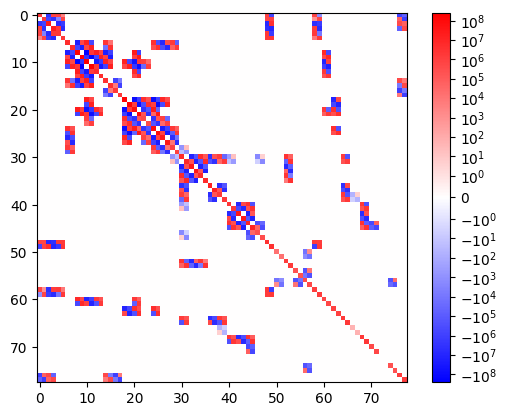

In [12]:
# Test the optimal buses
weighted_fims_configs = fim_configs_tensor * wopt.reshape((-1, 1, 1))
I = np.sum(weighted_fims_configs[idx_wopt], axis=0)
print("Eigenvalues:")
print(np.linalg.eigvalsh(I))

plt.figure()
cbound = np.max([abs(np.min(I)), abs(np.max(I))])
plt.imshow(I, cmap="bwr", norm=mpl.colors.SymLogNorm(1e0, vmin=-cbound, vmax=cbound))
plt.colorbar()
plt.show()